In [1]:
# Python packages
import pg_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

sns.set()
sns.set_theme(style="whitegrid")

# PostgreSQL connection
conn = pg_helper.postgresql_connect()
# Define dataframe column
column_names = ["debtorcode", "docdate", "itemcode", "qty", "taxamount", "category", "projno"]
# Select with Level 1 Data Cleaning
df_train = pg_helper.postgresql_to_dataframe(conn, "SELECT * FROM (SELECT ivz.\"DebtorCode\" AS debtorcode, ivz.\"DocDate\" AS docdate, ivdtlz.\"ItemCode\" AS itemcode, ivdtlz.\"Qty\" AS qty, ivdtlz.\"TaxCurrencyTaxableAmt\" AS taxamount, it.\"ItemType\" AS category, coalesce (1,NULL,1) AS projno FROM \"IVDTL\" AS ivdtlz INNER JOIN \"IV\" AS ivz ON ivdtlz.\"DocKey\"=ivz.\"DocKey\" INNER JOIN \"Item\" AS it ON it.\"ItemCode\" = ivdtlz.\"ItemCode\" WHERE ivdtlz.\"ItemCode\" IS NOT NULL AND ivdtlz.\"TaxCurrencyTaxableAmt\" > 0 AND \"ProjNo\" IS NULL AND ivz.\"DocDate\" < date_trunc('month', CURRENT_DATE) UNION ALL SELECT debtorcode, docdate, prodcode AS itemcode, cases AS qty, amount AS taxamount, category, COALESCE (0,NULL,0) AS projno FROM unilever_inv WHERE invtype='Normal' AND docdate < date_trunc('month', CURRENT_DATE)) AS na WHERE debtorcode IN (SELECT * FROM (SELECT ivz.\"DebtorCode\" AS debtorcode FROM \"IVDTL\" AS ivdtlz INNER JOIN \"IV\" AS ivz ON ivdtlz.\"DocKey\"=ivz.\"DocKey\" INNER JOIN \"Item\" AS it ON it.\"ItemCode\" = ivdtlz.\"ItemCode\" WHERE ivdtlz.\"ItemCode\" IS NOT NULL AND ivdtlz.\"TaxCurrencyTaxableAmt\" > 0 AND \"ProjNo\" IS NULL AND ivz.\"DocDate\" >= date_trunc('month', CURRENT_DATE- INTERVAL '3' month) UNION ALL SELECT debtorcode FROM unilever_inv WHERE invtype='Normal' AND docdate >= date_trunc('month', CURRENT_DATE- INTERVAL '3' MONTH)) na GROUP BY debtorcode)", column_names)
# Format data type
df_train["qty"] = df_train["qty"].astype("float64")
df_train["taxamount"] = df_train["taxamount"].astype("float64")
df_train["month_year"] = pd.to_datetime(df_train["docdate"]).dt.to_period("M")
df_train['month_year'] = df_train["month_year"].astype('object')
df_train["year"] = pd.to_datetime(df_train["docdate"]).dt.year
df_train["month"] = pd.to_datetime(df_train["docdate"]).dt.month
# df_train = df_train.set_index(["docdate"])
conn.close()

Connecting to the PostgreSQL database...
Connection successful


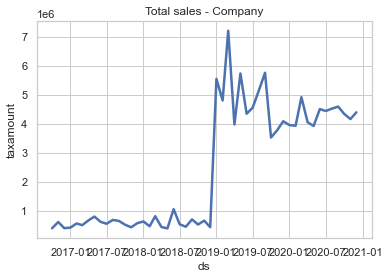

In [22]:
# Total sales - Company
df_groupall = df_train.groupby(['month_year']).agg({'taxamount':'sum'}).reset_index()
df_groupall["month_year"] = df_groupall["month_year"].astype("str")
df_groupall["ds"] = df_groupall["month_year"] + "-01 00:00:00.00000"
df_groupall['ds'] = pd.to_datetime(df_groupall['ds'])
df_groupall = df_groupall.set_index("ds")
df_groupall.drop('month_year', axis=1, inplace=True)
ax = sns.lineplot(data=df_groupall, y="taxamount", x=df_groupall.index, palette="tab10", linewidth=2.5).set_title("Total sales - Company")

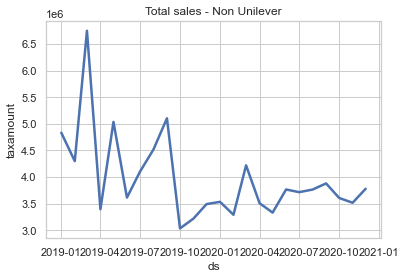

In [23]:
# Total sales - Non Unilever
df_groupall = df_train[df_train.projno == 1].groupby(['month_year']).agg({'taxamount':'sum'}).reset_index()
df_groupall["month_year"] = df_groupall["month_year"].astype("str")
df_groupall["ds"] = df_groupall["month_year"] + "-01 00:00:00.00000"
df_groupall['ds'] = pd.to_datetime(df_groupall['ds'])
df_groupall = df_groupall.set_index("ds")
df_groupall.drop('month_year', axis=1, inplace=True)
ax = sns.lineplot(data=df_groupall, y="taxamount", x=df_groupall.index, palette="tab10", linewidth=2.5).set_title("Total sales - Non Unilever")

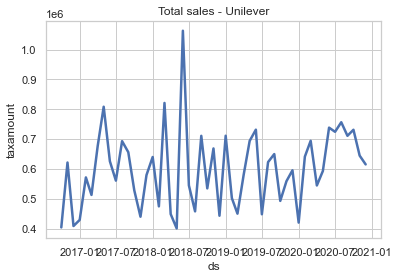

In [24]:
# Total sales - Unilever
df_groupall = df_train[df_train.projno == 0].groupby(['month_year']).agg({'taxamount':'sum'}).reset_index()
df_groupall["month_year"] = df_groupall["month_year"].astype("str")
df_groupall["ds"] = df_groupall["month_year"] + "-01 00:00:00.00000"
df_groupall['ds'] = pd.to_datetime(df_groupall['ds'])
df_groupall = df_groupall.set_index("ds")
df_groupall.drop('month_year', axis=1, inplace=True)
ax = sns.lineplot(data=df_groupall, y="taxamount", x=df_groupall.index, palette="tab10", linewidth=2.5).set_title("Total sales - Unilever")

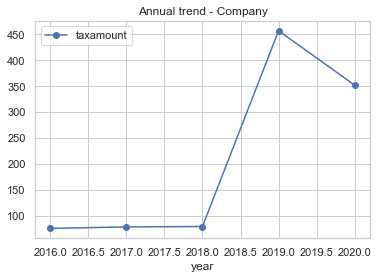

In [5]:
# Annual trend plot
_ = pd.pivot_table(df_train, values='taxamount', index='year').plot(style='-o', title="Annual trend - Company")

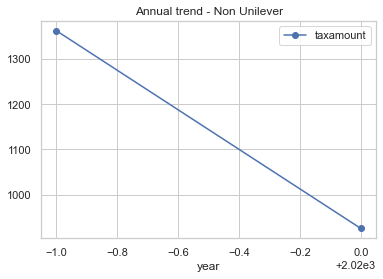

In [6]:
# Annual trend - Non Unilever
df_new0 = df_train[df_train.projno == 1]
_ = pd.pivot_table(df_new0, values='taxamount', index='year').plot(style='-o', title="Annual trend - Non Unilever")

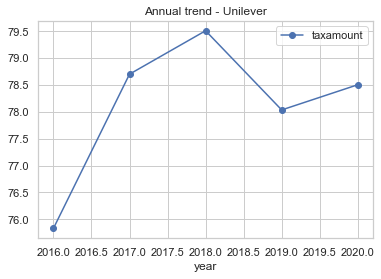

In [7]:
# Annual trend - Unilever
df_new0 = df_train[df_train.projno == 0]
_ = pd.pivot_table(df_new0, values='taxamount', index='year').plot(style='-o', title="Annual trend - Unilever")

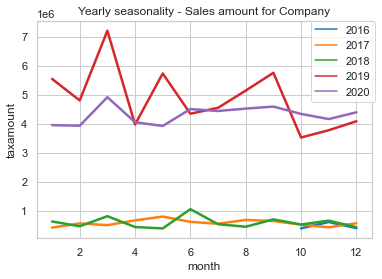

In [8]:
# Yearly seasonality - Sales amount for Company
df_new1 = df_train.groupby(["year", "month"], as_index=False).sum()
ax = sns.lineplot(data=df_new1, y="taxamount", x="month", hue="year", palette="tab10", linewidth=2.5).set_title("Yearly seasonality - Sales amount for Company")
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

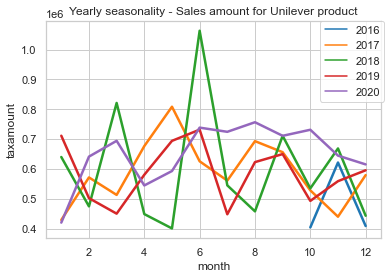

In [9]:
# Yearly seasonality - Sales amount for Unilever product
df_new0 = df_train[df_train.projno == 0].groupby(["year", "month"], as_index=False).sum()
ax = sns.lineplot(data=df_new0, y="taxamount", x="month", hue="year", palette="tab10", linewidth=2.5).set_title("Yearly seasonality - Sales amount for Unilever product")
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

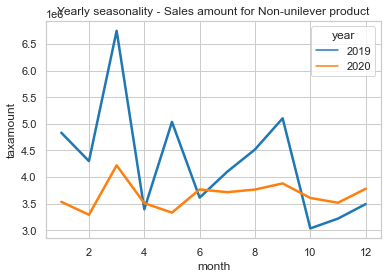

In [25]:
# Yearly seasonality - Sales amount for Non-unilever product
df_new1 = df_train[df_train.projno == 1].groupby(["year", "month"], as_index=False).sum()
ax = sns.lineplot(data=df_new1, y="taxamount", x="month", hue="year", palette="tab10", linewidth=2.5).set_title("Yearly seasonality - Sales amount for Non-unilever product")

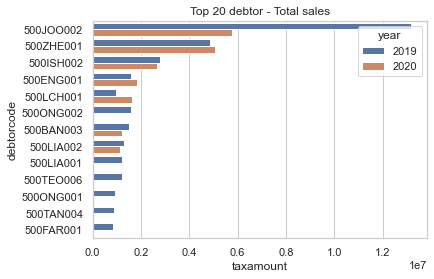

In [26]:
# Top 20 debtor - Total sales
df_debtorcode = df_train.groupby(["debtorcode","year"], as_index=False).sum().sort_values("taxamount", ascending=False).head(20)
ax = sns.barplot(y="debtorcode", x="taxamount", hue="year", data=df_debtorcode).set_title("Top 20 debtor - Total sales")

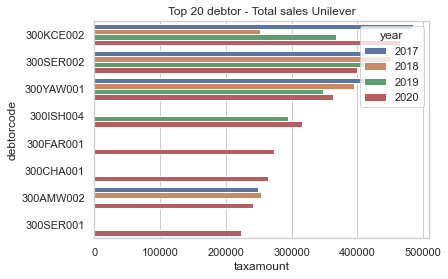

In [27]:
# Top 20 debtor - Total sales Unilever
df_debtorcode = df_train[df_train.projno == 0].groupby(["debtorcode","year"], as_index=False).sum().sort_values("taxamount", ascending=False).head(20)
ax = sns.barplot(y="debtorcode", x="taxamount", hue="year", data=df_debtorcode).set_title("Top 20 debtor - Total sales Unilever")

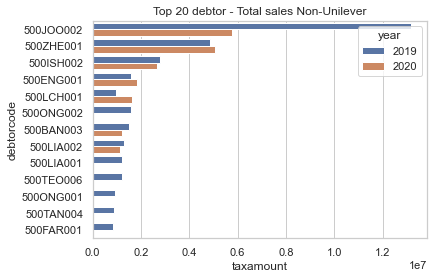

In [28]:
# Top 20 debtor - Total sales Non-Unilever
df_debtorcode = df_train[df_train.projno == 1].groupby(["debtorcode","year"], as_index=False).sum().sort_values("taxamount", ascending=False).head(20)
ax = sns.barplot(y="debtorcode", x="taxamount", hue="year", data=df_debtorcode).set_title("Top 20 debtor - Total sales Non-Unilever")

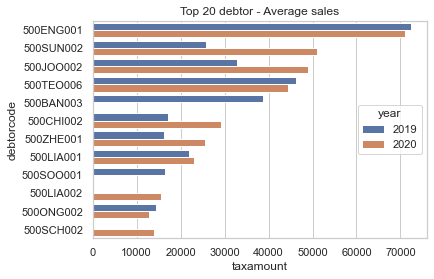

In [14]:
# Top 20 debtor - Average sales
df_debtorcode = df_train.groupby(["debtorcode","year"], as_index=False).mean().sort_values("taxamount", ascending=False).head(20)
ax = sns.barplot(y="debtorcode", x="taxamount", hue="year", data=df_debtorcode).set_title("Top 20 debtor - Average sales")

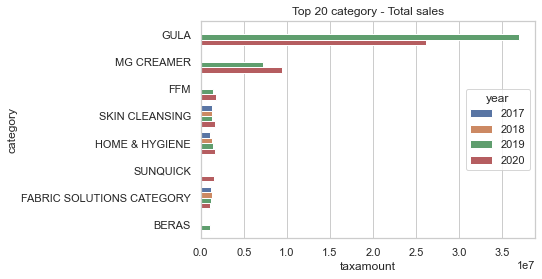

In [17]:
# Top 20 category - Total sales
df_itemcode = df_train.groupby(["category","year"], as_index=False).sum().sort_values("taxamount", ascending=False).head(20)
ax = sns.barplot(y="category", x="taxamount", hue="year", data=df_itemcode).set_title("Top 20 category - Total sales")

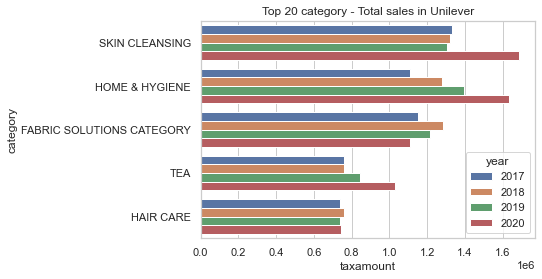

In [18]:
# Top 20 category - Total sales in Unilever
df_itemcode = df_train[df_train.projno == 0].groupby(["category","year"], as_index=False).sum().sort_values("taxamount", ascending=False).head(20)
ax = sns.barplot(y="category", x="taxamount", hue="year", data=df_itemcode).set_title("Top 20 category - Total sales in Unilever")

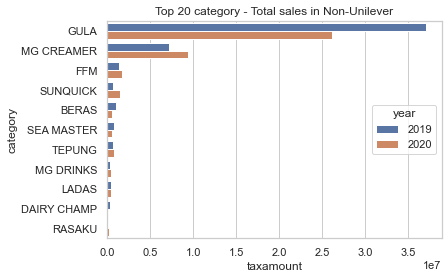

In [19]:
# Top 20 category - Total sales in Non-Unilever
df_itemcode = df_train[df_train.projno == 1].groupby(["category","year"], as_index=False).sum().sort_values("taxamount", ascending=False).head(20)
ax = sns.barplot(y="category", x="taxamount", hue="year", data=df_itemcode).set_title("Top 20 category - Total sales in Non-Unilever")

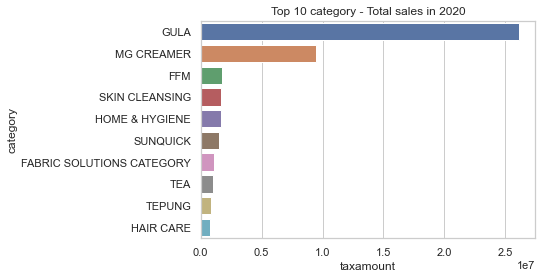

In [20]:
# Top 10 category - Total sales in 2020
df_debtorcode = df_train[df_train.year == 2020].groupby(["category", "year"], as_index=False).sum().sort_values("taxamount", ascending=False).head(10)
ax = sns.barplot(y="category", x="taxamount",  data=df_debtorcode).set_title("Top 10 category - Total sales in 2020")

Text(0.5, 1.0, 'Yearly seasonality - 2020')

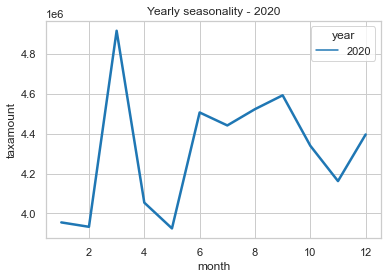

In [33]:
# Yearly seasonality - 2020
df_new2020 = df_train[df_train.year == 2020].groupby(["year", "month"], as_index=False).sum()
sns.lineplot(data=df_new2020, y="taxamount", x="month", hue="year", palette="tab10", linewidth=2.5).set_title("Yearly seasonality - 2020")

Text(0.5, 1.0, 'Yearly seasonality - 2019')

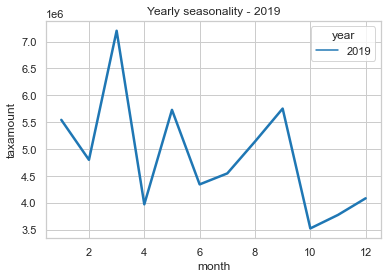

In [29]:
# Yearly seasonality - 2019
df_new2019 = df_train[df_train.year == 2019].groupby(["year", "month"], as_index=False).sum()
sns.lineplot(data=df_new2019, y="taxamount", x="month", hue="year", palette="tab10", linewidth=2.5).set_title("Yearly seasonality - 2019")

Text(0.5, 1.0, 'Yearly seasonality - 2018')

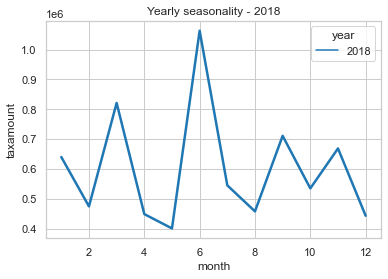

In [30]:
# Yearly seasonality - 2018
df_new2018 = df_train[df_train.year == 2018].groupby(["year", "month"], as_index=False).sum()
sns.lineplot(data=df_new2018, y="taxamount", x="month", hue="year", palette="tab10", linewidth=2.5).set_title("Yearly seasonality - 2018")

Text(0.5, 1.0, 'Yearly seasonality - 2017')

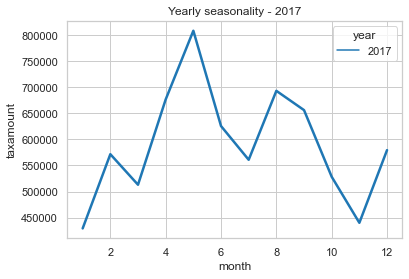

In [31]:
# Yearly seasonality - 2017
df_new2017 = df_train[df_train.year == 2017].groupby(["year", "month"], as_index=False).sum()
sns.lineplot(data=df_new2017, y="taxamount", x="month", hue="year", palette="tab10", linewidth=2.5).set_title("Yearly seasonality - 2017")